
#Import Packages



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import shap

## Overview of the Data

Before diving into model building, it's essential to get a high-level understanding of our dataset. This includes understanding the structure of the data, key features, and any initial patterns or trends.


1. **Loading the Data**: We'll load the dataset and get a quick overview of what we're dealing with.


In [2]:
df = pd.read_csv("/content/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#Drop Unnecessary Columns
We recognize that the `customerID` column is not relevant for our analysis, as it serves only as a unique identifier, and can therefore be safely dropped from the dataset.

In [3]:
df = df.drop('customerID',axis='columns')

# Exploring Data Types

We examine the data types of each column to ensure they are correctly assigned, as this will impact how we process and analyze the data. Any necessary conversions will be made to align with the requirements of our
XGBoost.

In [4]:
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


#Data Type Adjustments

Upon exploring the data types, we realize that the `TotalCharges` column is stored as a string. Since this column contains numerical information, we will need to convert it to a numeric data type for accurate analysis and modeling.


In [5]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [6]:
df_cleaned_types = df[df.TotalCharges != ' '].copy()
df_cleaned_types['TotalCharges'] = pd.to_numeric(df_cleaned_types['TotalCharges'])
df_cleaned_types.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


#Exploring Unique Values of Categorical Columns

To better understand the categorical features in our dataset, we will:

1. **Examine unique values**: This helps us identify all possible categories within each non-numerical column.
2. **Spot inconsistencies**: We may find categories that are essentially the same but labeled differently (e.g., "Yes it does" vs "yes"). These will be combined to ensure consistency.
3. **Convert categories to numbers**: Once the categories are standardized, we will transform them into numerical representations, using techniques like label encoding or one-hot encoding, to make the data suitable for modeling.


In [7]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

In [8]:
print_unique_col_values(df_cleaned_types)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [9]:
df_cleaned_types = df_cleaned_types.replace('No internet service', 'No')
df_cleaned_types = df_cleaned_types.replace('No phone service', 'No')

In [10]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df_cleaned_types[col].replace({'Yes': 1,'No': 0},inplace=True)

In [11]:
df_cleaned_types['gender'].replace({'Female':1,'Male':0},inplace=True)

In [12]:
print_unique_col_values(df_cleaned_types)

InternetService: ['DSL' 'Fiber optic' 'No']
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [13]:
df_numerical = pd.get_dummies(data=df_cleaned_types, columns=['InternetService', 'Contract', 'PaymentMethod']).astype(int)

In [14]:
df_numerical.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4885,0,1,1,0,72,1,1,0,1,1,...,0,1,0,0,0,1,1,0,0,0
6034,1,0,0,0,7,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2201,1,0,0,0,36,1,0,1,1,1,...,1,0,0,0,1,0,1,0,0,0
2656,1,0,0,0,39,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3064,1,0,0,0,21,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [15]:
df_numerical.dtypes

,0
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
OnlineSecurity,int64
OnlineBackup,int64
DeviceProtection,int64


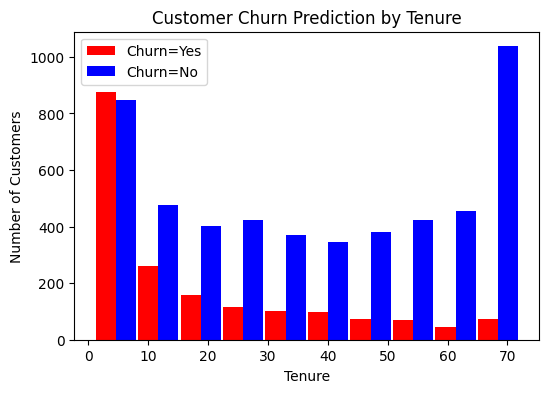

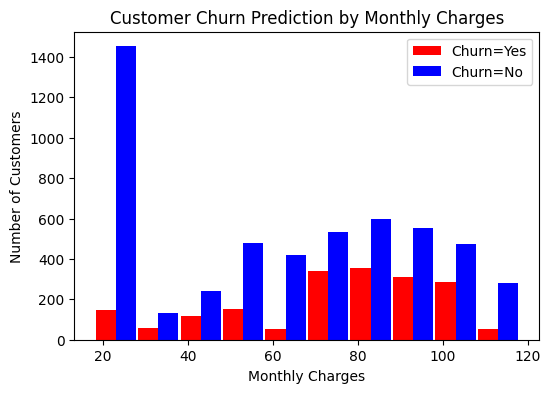

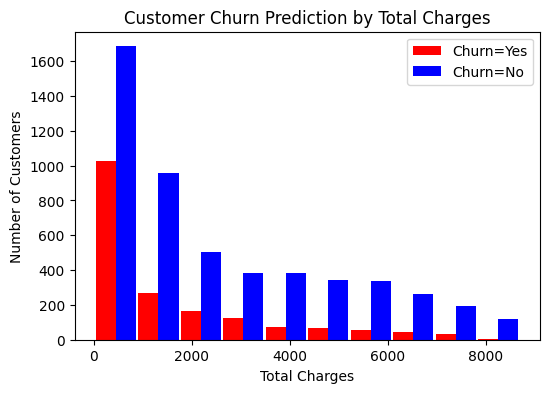

In [16]:
def plot_churn_histogram(df, column, xlabel, title, churn_col='Churn'):
    churn_no = df[df[churn_col] == 0][column]
    churn_yes = df[df[churn_col] == 1][column]

    plt.figure(figsize=(6, 4))
    plt.hist([churn_yes, churn_no], rwidth=0.95, color=['red', 'blue'], label=['Churn=Yes', 'Churn=No'])
    plt.xlabel(xlabel)
    plt.ylabel("Number of Customers")
    plt.title(title)
    plt.legend()
    plt.show()

plot_churn_histogram(df_numerical, 'tenure', "Tenure", "Customer Churn Prediction by Tenure")

plot_churn_histogram(df_numerical, 'MonthlyCharges', "Monthly Charges", "Customer Churn Prediction by Monthly Charges")

plot_churn_histogram(df_numerical, 'TotalCharges', "Total Charges", "Customer Churn Prediction by Total Charges")


# Normalizing Features

To ensure that all features contribute equally to the model, we will normalize the numerical columns. This process scales the values so that they fall within a similar range, preventing features with larger magnitudes from disproportionately influencing the model.

In [17]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']
scaler = MinMaxScaler()
df_numerical[cols_to_scale] = scaler.fit_transform(df_numerical[cols_to_scale])

In [18]:
for col in df_numerical:
    print(f'{col}: {df_numerical[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

# Checking Dataset Balance

Before proceeding with model training, it's crucial to check if our dataset is balanced, especially for the target variable. An imbalanced dataset, where one class significantly outweighs the other(s), can lead to biased predictions.

If the dataset is found to be imbalanced, we will apply the **SMOTE (Synthetic Minority Over-sampling Technique)**. SMOTE generates synthetic samples rather than simply duplicating existing entries, helping to reduce the risk of overfitting while balancing the dataset.


In [19]:
df_numerical['Churn'].value_counts()

,count
Churn,
0,5163
1,1869


In [20]:
smote = SMOTE(random_state=1234)

X_resampled, y_resampled = smote.fit_resample(df_numerical.drop('Churn', axis=1), df_numerical['Churn'])

df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=df_numerical.drop('Churn', axis=1).columns),
                         pd.DataFrame(y_resampled, columns=['Churn'])], axis=1)

df_balanced['Churn'].value_counts()

,count
Churn,
0,5163
1,5163


#Splitting the Data: Train-Test Split

To evaluate the performance of our model, we will split the dataset into two parts: **training** and **testing** sets. The training set will be used to train the model, while the testing set will serve as unseen data to validate the model's performance. This ensures that the model generalizes well to new data and prevents overfitting.


In [21]:
X = df_balanced.drop('Churn', axis='columns')
y = df_balanced['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Choosing XGBoost for Telco Customer Churn

For this Telco Customer Churn project, I will be using **XGBoost (Extreme Gradient Boosting)**, a powerful and efficient machine learning algorithm that excels in classification tasks that use tabular data. XGBoost is well-suited for our problem due to several reasons:

1. **Speed and Performance**: XGBoost is highly optimized for speed and performance, making it ideal for large datasets and fast computation.
2. **Feature Importance**: It provides insights into feature importance, which can help identify key factors influencing customer churn.
3. **Regularization**: XGBoost implements L1 and L2 regularization to prevent overfitting, ensuring the model generalizes well to unseen data.

These features make XGBoost a robust choice for predicting customer churn with high accuracy and efficiency.

In [22]:
model = XGBClassifier(n_estimators=100,
                      max_depth=8,
                      learning_rate=0.1,
                      colsample_bytree=0.6,
                      objective='binary:logistic',
                      random_state=1234)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train,
          eval_set=eval_set,
          verbose=False)

preds = model.predict(X_test)

#Plotting Loss Graphs for Training and Testing Data

To evaluate the performance of our model during training, we will plot the **loss curves** for both the training and testing datasets. These graphs provide valuable insights into the model's learning process:

1. **Training Loss**: This curve shows how well the model is fitting the training data over time. A steadily decreasing loss indicates that the model is learning the underlying patterns.
2. **Testing Loss**: This curve helps us monitor how well the model generalizes to unseen data. If the testing loss remains low, it suggests good generalization. However, if the testing loss increases while the training loss continues to decrease, it may indicate **overfitting**.

By comparing the two curves, we can detect issues such as underfitting or overfitting and adjust the model accordingly.


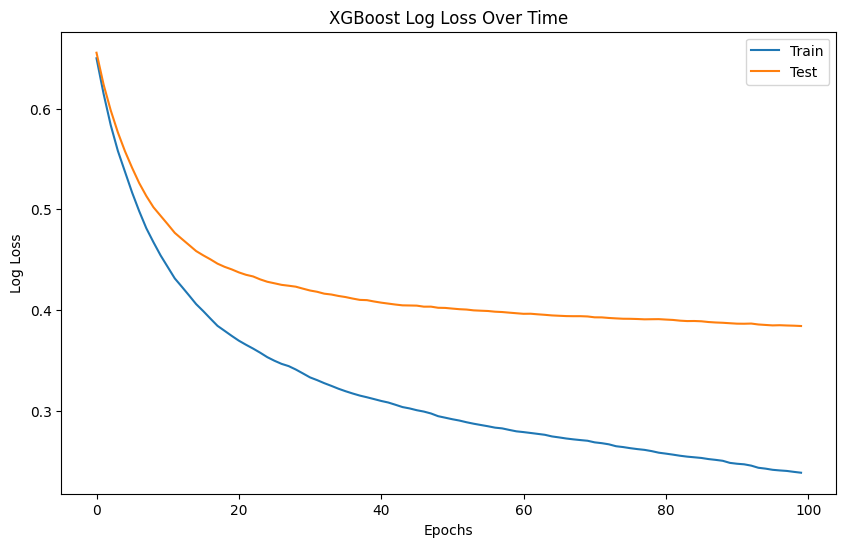

In [23]:
results = model.evals_result()

epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Time')
plt.legend()
plt.show()

### Evaluating Model Performance: Accuracy, Precision, Recall, and F1-Score

A confusion matrix is a detailed summary of a classification model's performance. It compares actual versus predicted values, breaking down results into four categories: true positives, true negatives, false positives, and false negatives. In addition to the confusion matrix, we use several key metrics to assess the effectiveness of our classification model. These metrics provide a deeper understanding of the model's performance:

1. **Accuracy**: The proportion of total predictions that were correct. While useful, accuracy can be misleading in imbalanced datasets, as it doesn’t distinguish between the types of errors.

   $$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

2. **Precision**: The proportion of correctly predicted positive observations out of all predicted positives. High precision means fewer false positives.

   $$ \text{Precision} = \frac{TP}{TP + FP} $$

3. **Recall (Sensitivity or True Positive Rate)**: The proportion of actual positive observations that were correctly predicted. High recall means fewer false negatives.

   $$ \text{Recall} = \frac{TP}{TP + FN} $$

4. **F1-Score**: The harmonic mean of precision and recall, providing a balanced measure when there is an uneven class distribution. The F1-score is particularly useful for imbalanced datasets.

   $$ \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

These metrics, derived from the confusion matrix, allow us to assess the model's ability to handle both positive and negative predictions and avoid biases that can arise from imbalanced data. By considering all of these measures, we ensure a more comprehensive evaluation of the model’s performance.

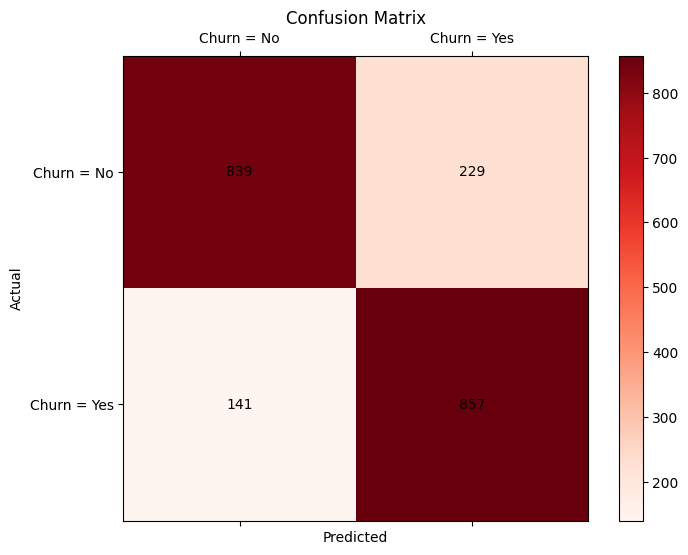

In [24]:
cm = confusion_matrix(y_test, preds)

labels = ['Churn = No', 'Churn = Yes']

plt.figure(figsize=(8, 6))
plt.matshow(cm, cmap=plt.cm.Reds, fignum=1)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f'{val}', ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.show()


In [25]:
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.2f}")
report = classification_report(y_test, preds)
print("Classification Report:")

Accuracy: 0.82
Classification Report:


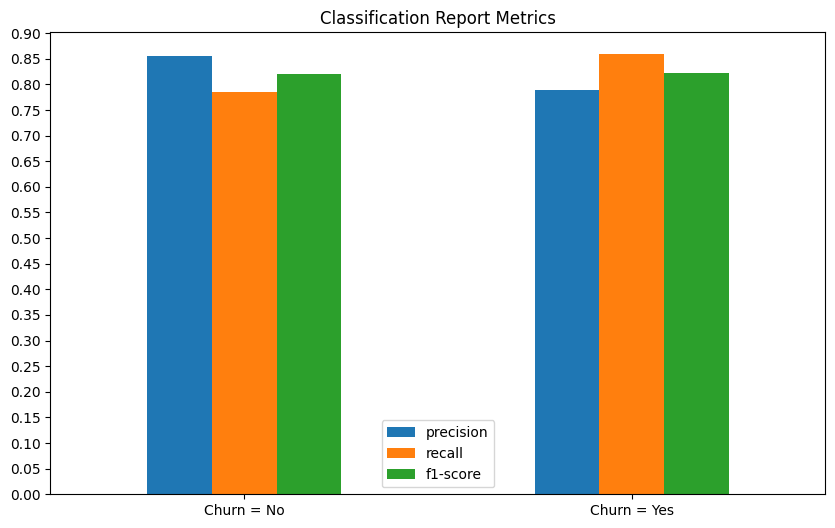

In [26]:
report = classification_report(y_test, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

metrics = df_report.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
metrics.rename(index={'0': 'Churn = No', '1': 'Churn = Yes'}, inplace=True)

ax = metrics[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
ax.set_yticks([i/100 for i in range(0, 91, 5)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.title("Classification Report Metrics")
plt.show()

#Understanding Feature Importance

To get a clearer picture of which features are most important in our model, we will use two methods:

1. **XGBoost Built-in Feature Importance**: This provides a quick ranking of the most influential features in making predictions.
   
2. **SHAP**: SHAP offers another way to visualize feature importance and understand how each feature contributes to the model’s output. While we will use SHAP for general feature importance, it can also be leveraged for even more detailed explanations if needed.

Using both methods allows us to compare and confirm the key features that influence customer churn predictions.

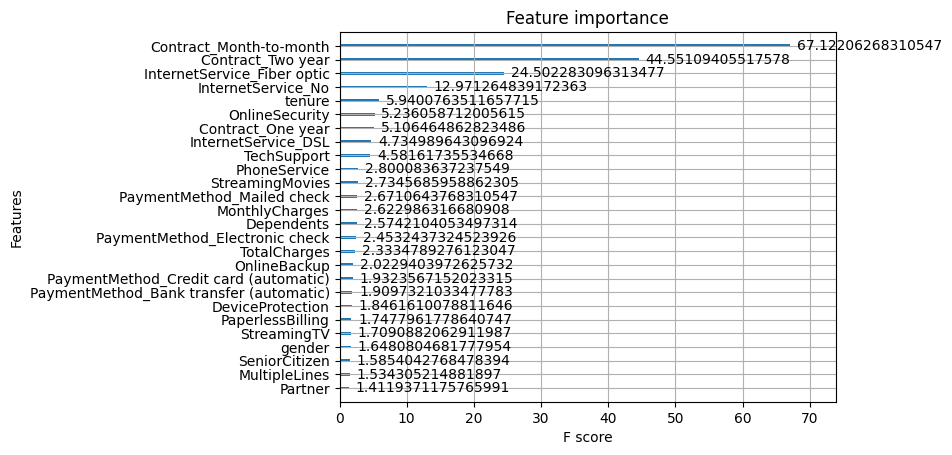

In [27]:
xgb.plot_importance(model, importance_type='gain')
plt.show()

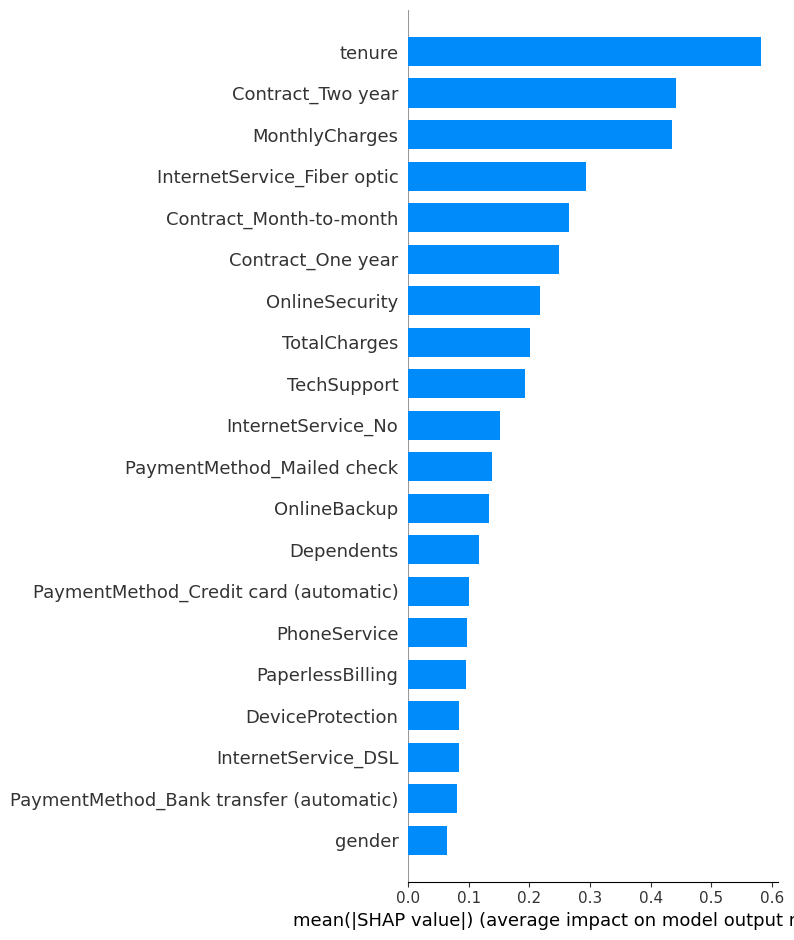

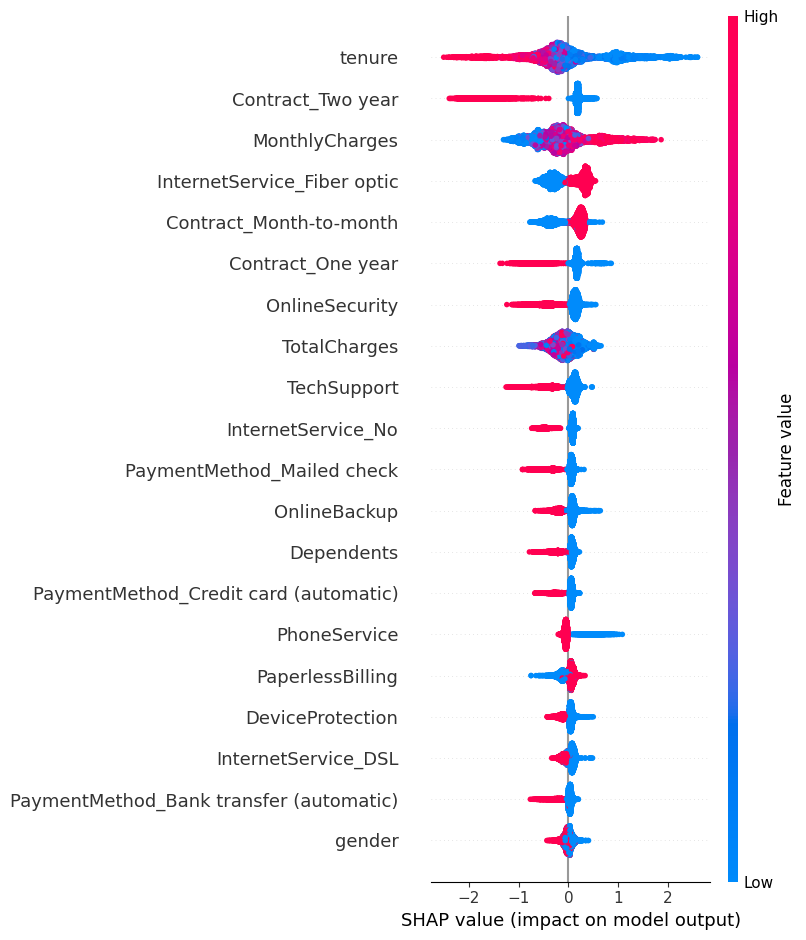

In [28]:
explainer = shap.Explainer(model)

shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

shap.summary_plot(shap_values, X_train)